# Movie Recommendations based Wikilinks

Movie recommendation systems are usually based on ratings. The code below though only looks at links from the wikipedia pages of movies. The intuition here is that movies that are similar, will link to similar entities. This could be style, actors, directors or time periods.

We train an embedding model that tries to predict whether two movies both link to an entity or not. We can then use the resulting embedding vectors to find nearest neighbors and create something that says, if you like this movie, try out also that movie.

First start with a bunch of imports:

In [1]:
%matplotlib inline

import os
import numpy as np

import psycopg2
import psycopg2.extras
from itertools import chain
from collections import Counter, defaultdict
import requests
import imageio

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from io import BytesIO
from hashlib import md5
from IPython.display import display, HTML

from itertools import chain
import mwparserfromhell

from keras.models import Model
from keras.layers import Embedding, Dense, Input, Lambda, Reshape, merge
import keras.backend as K
from keras.layers.merge import Dot

from sklearn.manifold import TSNE

Using TensorFlow backend.


The fetch_image function below fetches an image from wikipedia given a wikipedia id for that image:

In [2]:
IMAGE_PATH_EN = 'http://upload.wikimedia.org/wikipedia/en/%s/%s/%s'
IMAGE_PATH_COMMONS = 'http://upload.wikimedia.org/wikipedia/commons/%s/%s/%s'
image_cache = 'movie_images'

def fetch_image(image_name):
    if not image_name or image_name.endswith('.tiff'):
        return None
    image_name = image_name.replace(' ', '_')
    if image_name[0].upper() != image_name[0]:
        image_name = image_name.capitalize()
    file_path = os.path.join(image_cache, image_name)
    if os.path.isfile(file_path):
        return image_name
    else:
        m = md5()
        m.update(image_name.encode('utf-8'))
        c = m.hexdigest()
        path = IMAGE_PATH_EN % (c[0], c[0:2], image_name)
        r = requests.get(path)
        if r.status_code == 404:
            path = IMAGE_PATH_COMMONS % (c[0], c[0:2], image_name)
            r = requests.get(path)
            if r.status_code == 404:
                print image_name
                return None
        try:
            image = Image.open(BytesIO(r.content))
        except IOError:
            return None
        except ValueError:
            return None
        image.save(file(file_path, 'w'))
        image.thumbnail((240, 640), Image.ANTIALIAS)
        res = BytesIO()
        if image.mode == 'P':
            image = image.convert('RGB')
        try:
            image.save(res, 'WEBP', quality=15)
        except IOError as err:
            print image_name, err.message
            return None
        return image_name

fetch_image('Suicide Squad (film) Poster.png')

'Suicide_Squad_(film)_Poster.png'

The code here relies on wikipedia having been imported into Postgres using [Wiki Import](https://github.com/DOsinga/wiki_import). So we setup a connection to postgres, fetch the 10000 most popular movies and then extract for each the movie name, the image for the movie and the outgoing links from that page

In [3]:
postgres_conn = psycopg2.connect('dbname=douwe user=notebook')
postgres_cursor = postgres_conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

In [4]:
print 'Getting top movies...'
postgres_cursor.execute(
    "SELECT wikipedia.*, wikistats.viewcount FROM wikipedia "
    "JOIN wikistats ON wikipedia.title = wikistats.title WHERE wikipedia.infobox = 'film' "
    "ORDER BY wikistats.viewcount DESC limit 10000"
)
print 'done'

Getting top movies...
done


In [5]:
movies = []
for movie in postgres_cursor:
    wikicode = mwparserfromhell.parse(movie['wikitext'])
    image = None
    for template in wikicode.filter_templates():
        if template.name.lower().startswith('infobox '):
            for param in template.params:
                key = param.name.strip()
                if key == 'image':
                    image = param.value.strip()
            break
    if image:
        image_name = fetch_image(image)
    movies.append((movie['title'], image_name, [unicode(x.title) for x in wikicode.filter_wikilinks()], movie['viewcount']))

len(movies)


Veyil4.jpg


10000

Now that we have all the movies, extract all the outgoing links (refs) and keep the ones that are used more than once.

In [6]:
ref_counts = Counter()
for _, _, refs, _ in movies:
    ref_counts.update(refs)
all_refs = [ref for ref, count in ref_counts.items() if count > 1]
ref_to_id = {ref: idx for idx, ref in enumerate(all_refs)}
movie_to_id = {title: idx for idx, (title, _, _, _) in enumerate(movies)}
len(all_refs), len(ref_counts)


(101797, 218227)

Now createthe refs_movie structure that holds for each ref, the movies that refer to it:

In [7]:
refs_movies = defaultdict(list)
for movie, image, refs, viewcounts in movies:
    movie_id = movie_to_id[movie]
    for ref in refs:
        ref_id = ref_to_id.get(ref)
        if ref_id:
            refs_movies[ref_id].append(movie_id)
refs_movies = list(refs_movies.items())
len(refs_movies)

101796

We now construct a generator that yields tupels that encode whether or not two movies link to the same entity. (The generator can also be used with yield_movie_pairs=False to get movie/entity pairs). +1 indicates co-occurance, -1 indicates non occurance:

In [8]:
import random
random.seed(5)

def data_generator(refs_movies, negative_ratio=5, yield_movie_pairs=True):
    random.shuffle(refs_movies)
    for ref, movies in refs_movies:
        if yield_movie_pairs:
            if len(movies) < 2: continue
            a, b = random.sample(movies, 2)
        else:
            a = ref
            b = random.choice(movies)
        yield a, b, 1

        seen = set(movies)
        left = negative_ratio
        while left > 0:
            n = random.randrange(len(movie_to_id))
            if not n in seen:
                left -= 1
                seen.add(n)
                yield a, n, -1


def batchify(gen, batch_size):
    ax, bx, lx = [], [], []
    while True:
        for a, b, label in gen():
            ax.append(a)
            bx.append(b)
            lx.append(label)
            if len(ax) > batch_size:
                yield { 'first': np.asarray(ax), 'second': np.asarray(bx)}, np.asarray(lx)
                del ax[:]
                del bx[:]
                del lx[:]

next(batchify(lambda: data_generator(refs_movies), batch_size=10))

({'first': array([8597, 8597, 8597, 8597, 8597, 8597,  145,  145,  145,  145,  145]),
  'second': array([8704, 1377,  405, 3232, 7740, 6794,  245, 4028, 8469, 9101, 9537])},
 array([ 1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1]))

The model itself is fairly straightforward:

In [9]:
N = 20

def model_simple():
    src = Input(name='first', shape=(1,))
    dst = Input(name='second', shape=(1,))
    src_embedding = Embedding(name='src_embedding', input_dim=len(movie_to_id), output_dim=N)(src)
    dst_embedding = Embedding(name='dst_embedding', input_dim=len(movie_to_id), output_dim=N)(dst)
    dot = merge([src_embedding, dst_embedding], mode='cos')
    dot = Reshape((1,))(dot)
    model = Model(inputs=[src, dst], outputs=[dot])
    model.compile(optimizer='nadam', loss='mse')
    return model

model = model_simple()

/home/notebook/notebook/venv2/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/notebook/notebook/venv2/local/lib/python2.7/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


It converges quite quickly too. The achieved loss isn't super impressive - 0.4 or so:

In [10]:
model.fit_generator(
    batchify(lambda: data_generator(refs_movies, yield_movie_pairs=True), 2048),
    epochs=25,
    steps_per_epoch=3500,
    verbose=2
)

Epoch 1/25
24s - loss: 0.5171
Epoch 2/25
24s - loss: 0.4338
Epoch 3/25
24s - loss: 0.4276
Epoch 4/25
24s - loss: 0.4248
Epoch 5/25
24s - loss: 0.4230
Epoch 6/25
24s - loss: 0.4218
Epoch 7/25
24s - loss: 0.4209
Epoch 8/25
24s - loss: 0.4203
Epoch 9/25
24s - loss: 0.4197
Epoch 10/25
24s - loss: 0.4192
Epoch 11/25
24s - loss: 0.4189
Epoch 12/25
24s - loss: 0.4184
Epoch 13/25
24s - loss: 0.4183
Epoch 14/25
24s - loss: 0.4180
Epoch 15/25
24s - loss: 0.4178
Epoch 16/25
24s - loss: 0.4177
Epoch 17/25
24s - loss: 0.4174
Epoch 18/25
24s - loss: 0.4173
Epoch 19/25
24s - loss: 0.4172
Epoch 20/25
24s - loss: 0.4170
Epoch 21/25
24s - loss: 0.4169
Epoch 22/25
24s - loss: 0.4170
Epoch 23/25
24s - loss: 0.4167
Epoch 24/25
24s - loss: 0.4167
Epoch 25/25
24s - loss: 0.4166


Extract the weights for the movie embeddings:

In [11]:
src = model.get_layer('src_embedding')
src_weights = src.get_weights()[0]
lens = np.linalg.norm(src_weights, axis=1)
normalized = (src_weights.T / lens).T
np.linalg.norm(normalized[0]), normalized.shape

(1.0, (10000, 20))

Test whether it works by looking for "star wars" related movies.

In [12]:
def neighbors(movie):
    dists = np.dot(normalized, normalized[movie_to_id[movie]])
    closest = np.argsort(dists)[-10:]
    for c in closest:
        print(c, movies[c][0], dists[c])

neighbors('Star Wars (film)')

(6444, 'Return of the Ewok', 0.95703477)
(683, 'Superman (1978 film)', 0.95719445)
(9456, 'Doppelg\xc3\xa4nger (1969 film)', 0.95741284)
(4145, 'Dragonslayer', 0.96169114)
(639, 'Indiana Jones and the Temple of Doom', 0.9632467)
(141, 'Alien (film)', 0.96762782)
(303, 'Raiders of the Lost Ark', 0.98218834)
(44, 'Return of the Jedi', 0.98419368)
(74, 'The Empire Strikes Back', 0.98707592)
(18, 'Star Wars (film)', 0.99999988)


Another way to explore the data is by using TSNE to group the movies on a two dimensional grid. 

In [13]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
xy = model.fit_transform(normalized)
xy

array([[ 3.04852687, -1.84250886],
       [ 5.80860702, -2.40014016],
       [ 3.10556136, -1.96007714],
       ..., 
       [ 5.74482433,  3.30837116],
       [ 4.40213956, -3.6699006 ],
       [-0.18579654, -0.58216759]])

Scatter Plot the first 300 movies to get an idea of whether what the shape is we are looking at:

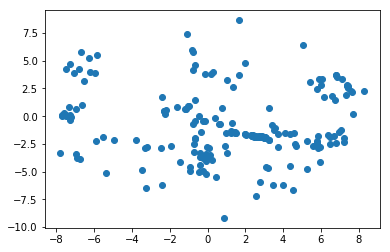

In [14]:
plt.scatter(xy[:,0][:200], xy[:,1][:200])
plt.show()

We can now create a large bitmap that has the movie posters of all movies on it which we can then use to interactively explore neighborhoods of movies. We just loop through all the movies in reverse order and plot them at the position where they are needed, making sure to 

In [40]:
w = 144
h = 220
res = []
sz = 100
sz_1 = sz + 1
taken = [[False] * sz_1 for _ in range(sz_1)]
x_min = xy.T[0].min()
y_min = xy.T[1].min()
x_max = xy.T[0].max()
y_max = xy.T[1].max()
img = Image.new('RGB', (sz_1 * w, sz_1 * h))
drw = ImageDraw.Draw(img)
c1 = 0
c2 = 0
for movie, coo in zip(movies, xy):
    if not movie[1]:
        continue
    poster = Image.open(image_cache + '/' + movie[1])
    poster.thumbnail((w, h), Image.ANTIALIAS)
    x = int(sz * (coo[0] - x_min) / (x_max - x_min))
    y = int(sz * (coo[1] - y_min) / (y_max - y_min))
    if taken[x][y]:
        c1 += 1
        for dx, dy in (-1, 0), (2, 0), (-1, -1), (0, 2):
            x += dx
            y += dy
            if x >= 0 and y >= 0 and x < sz_1 and y < sz_1 and not taken[x][y]:
                break
        else:
            continue
        c2 += 1
    taken[x][y] = True
    x *= w
    y *= h
    drw.rectangle((x, y, x + w, y + h), (50, 50, 50))
    res.append((x, y, movie[1], poster.size[0], poster.size[1]))
    img.paste(poster, (x + (w - poster.size[0]) / 2, y  + (h - poster.size[1]) / 2))

img.save(open('/home/notebook/notebook/poster.png', 'wb'))
    
x_min, y_min, x_max, y_max, c1, c2

(-9.1501788539350546,
 -9.2011315734468635,
 9.3792594010873813,
 8.6547486666455313,
 7325,
 2396)

As a last step, we write the resulting data back into the database to power the interactive demo

In [41]:
cursor = postgres_conn.cursor()
cursor.execute('DROP TABLE IF EXISTS movie_recommender')
cursor.execute('CREATE TABLE movie_recommender ('
               '    wikipedia_id TEXT PRIMARY KEY,'
               '    viewcount INT,'
               '    image TEXT,'
               '    x FLOAT,'
               '    y FLOAT,'
               '    vec FLOAT[] NOT NULL DEFAULT \'{}\''
               ')')
cursor.execute('CREATE INDEX movie_recommender_vec ON movie_recommender USING gin(vec)')
cursor.execute('CREATE INDEX movie_recommender_name_pattern ON movie_recommender USING btree(lower(wikipedia_id) text_pattern_ops)')
cursor.execute('CREATE INDEX movie_recommender_viewcount ON movie_recommender(viewcount)')


In [42]:
for movie, coo, weights in zip(movies, xy, src_weights):
    x = int(sz * (coo[0] - x_min) / (x_max - x_min)) * w
    y = int(sz * (coo[1] - y_min) / (y_max - y_min)) * h
    v_len = np.linalg.norm(weights)
    cursor.execute('INSERT INTO movie_recommender (wikipedia_id, image, viewcount, x, y, vec) '
                   'VALUES (%s, %s, %s, %s, %s, %s)',
                            (movie[0], movie[1], movie[-1], x, y,
                             [float(weight) / v_len for weight in weights]))
    

In [43]:
postgres_conn.commit()
cursor.close()

In [48]:
neighbors('Star Wars (film)')

(6444, 'Return of the Ewok', 0.95703477)
(683, 'Superman (1978 film)', 0.95719445)
(9456, 'Doppelg\xc3\xa4nger (1969 film)', 0.95741284)
(4145, 'Dragonslayer', 0.96169114)
(639, 'Indiana Jones and the Temple of Doom', 0.9632467)
(141, 'Alien (film)', 0.96762782)
(303, 'Raiders of the Lost Ark', 0.98218834)
(44, 'Return of the Jedi', 0.98419368)
(74, 'The Empire Strikes Back', 0.98707592)
(18, 'Star Wars (film)', 0.99999988)


In [49]:
coo = xy[639]
x = int(sz * (coo[0] - x_min) / (x_max - x_min)) * w
y = int(sz * (coo[1] - y_min) / (y_max - y_min)) * h
x, y

(5040, 11660)

In [50]:
frames = []
size = 4800
i = 0
x1 = x + 75
y1 = y + 200
while size > 480:
    width2 = int(size / 2)
    height2 = int(size / 3)
    img_crop = img.crop((x1 - width2, y1 - height2, x1 + width2, y1 + height2))
    img_crop = img_crop.resize((600, 400))
    fn = 'movie_images/frame_%d.png' % i
    img_crop.save(fn)
    frames.append(fn)
    size /= 1.2
    i += 1
len(frames)

13

In [51]:
imageio.mimsave('movie_recommend.gif', [imageio.imread(frame) for frame in frames], 'GIF', duration=0.5)
display(HTML('<img src="movie_recommend.gif">'))